## Basic setup

In [107]:
import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
from torchvision import datasets, transforms

from collections import OrderedDict

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [40]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

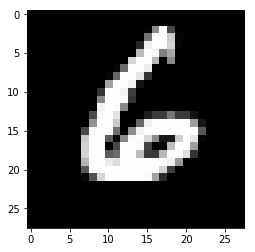

In [44]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

In [171]:
def view_classify(img, ps):
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()
    plt.title(np.argmax(ps))

## Training network in different frameworks

### PyTorch

In [245]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('output_layer', nn.Linear(hidden_sizes[1], output_size)),
                      ('logits', nn.Softmax(dim=1))]))

In [249]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [250]:
epochs = 3
print_every = 40
steps = 0
for e in range(epochs):
    running_loss = 0
    for images, labels in iter(trainloader):
        steps += 1
        images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            print("\rEpoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every), end='')
            
            running_loss = 0

Epoch: 3/3...  Loss: -0.3543

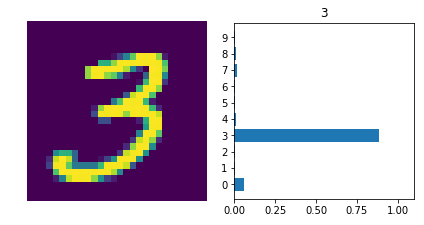

In [261]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

images.resize_(64, 1, 784)

img_idx = 0
ps = model.forward(images[img_idx,:])

img = images[img_idx]
view_classify(img.view(1, 28, 28), ps.data.numpy().squeeze())

### Tensorflow

In [264]:
class TfNetwork:
    def __init__(self):
        self.sess = tf.Session()
        self.input = tf.placeholder(tf.float32, shape=(None, 1, 28, 28))
        self.output = self.inference()
        
    def inference(self):
        with tf.name_scope('classificator'):
            flattener = tf.layers.flatten(self.input)
            layer = tf.layers.dense(flattener, 128, activation=tf.nn.relu)
            layer = tf.layers.dense(layer, 64, activation=tf.nn.relu)
            output = tf.layers.dense(layer, 10, activation=tf.nn.relu)
            
        return output
    
    def _get_training_graph(self):
        y_input = tf.placeholder(tf.float32, shape=(None, 10))
        
        with tf.name_scope('training'):
            loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(onehot_labels=y_input, logits=self.output))
            optimize = tf.train.AdagradOptimizer(learning_rate=0.01).minimize(loss)
            
        return y_input, loss, optimize
    
    def train(self, epochs):
        y_input, loss, optimize = self._get_training_graph()
            
        self.sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])
        print_every = 40
        for e in range(epochs):
            running_loss = 0
            steps=0
            
            for images, labels in iter(trainloader):
                steps+=1
                b = np.zeros((len(labels), 10))
                b[np.arange(len(labels)), labels] = 1
                
                answ, _ = self.sess.run([loss, optimize], feed_dict={self.input: images, y_input: b})
                running_loss += answ
                
                if steps % print_every == 0:
                    print("\rEpoch: {}/{}... ".format(e+1, epochs),
                      "Loss: {:.4f}".format(running_loss/print_every), end='')
                    running_loss = 0
                    
    def forward(self, X):
        softmax = tf.nn.softmax(self.output)
        return self.sess.run(softmax, feed_dict={self.input: X})
                
tf_nn = TfNetwork()
tf_nn.train(3)

Epoch: 3/3...  Loss: 0.4070

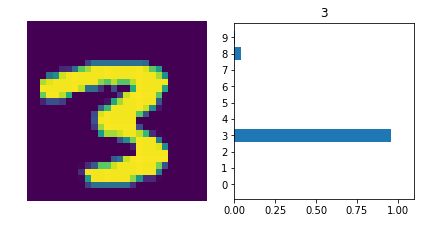

In [272]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

img_idx = 0
ps = tf_nn.forward([images[img_idx,:].numpy()])
images.resize_(64, 1, 784)
img = images[img_idx]
view_classify(img.view(1, 28, 28), ps[0])